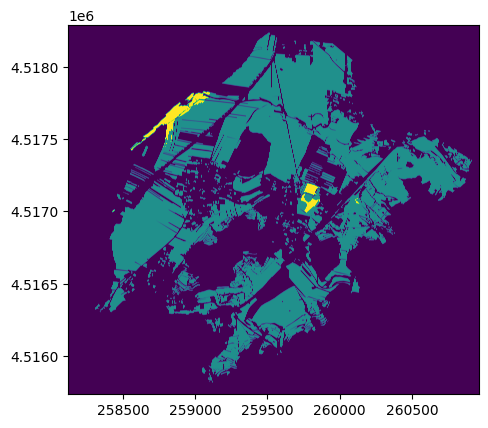

<Axes: >

In [2]:
import rasterio
from onnx.reference.ops.op_sigmoid import sigmoid
from rasterio.plot import show

standard_file_path = "../datasets/standard.tif"

# 打开tif文件
ds_standard = rasterio.open(standard_file_path)

show((ds_standard, 1))

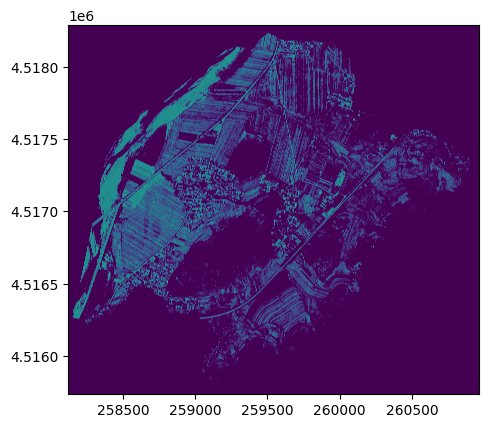

<Axes: >

In [3]:
example_file_path = "../datasets/submission_example.tif"

# 打开tif文件
ds_example = rasterio.open(example_file_path)

show((ds_example, 1))

In [3]:
standard_file_path = "../datasets/standard.tif"
result_file_path = "../datasets/main/result.tif"

In [7]:
import os
import rasterio

# 遍历根目录下的所有 tif 文件，保存它们的形状
for root, dirs, files in os.walk("../datasets"):
    for file in files:
        if file.endswith(".tif"):
            file_path = os.path.join(root, file)
            with rasterio.open(file_path) as src:
                data = src.read()
                print(f"File: {file_path}, Shape: {data.shape}")
                

File: ../datasets\standard.tif, Shape: (1, 39291, 43641)
File: ../datasets\submission_example.tif, Shape: (1, 39291, 43641)
File: ../datasets\main\dsm.tif, Shape: (1, 19631, 21804)
File: ../datasets\main\gsddsm.tif, Shape: (1, 3004, 3106)
File: ../datasets\main\result.tif, Shape: (4, 39291, 43641)
File: ../datasets\main\result_Green.tif, Shape: (1, 23127, 25687)
File: ../datasets\main\result_NIR.tif, Shape: (1, 23127, 25687)
File: ../datasets\main\result_Red.tif, Shape: (1, 23127, 25687)
File: ../datasets\main\result_RedEdge.tif, Shape: (1, 23127, 25687)


In [10]:
gsddsm_file_path = "../datasets/main/gsddsm.tif"
with rasterio.open(gsddsm_file_path) as src:
    print(src.meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 3106, 'height': 3004, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(1.11444032881991e-05, 0.0, 120.13365110273004,
       0.0, -7.93821087086144e-06, 40.78086412823033)}


In [11]:
gsddsm_file_path = "../datasets/main/result.tif"
with rasterio.open(gsddsm_file_path) as src:
    print(src.meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 43641, 'height': 39291, 'count': 4, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 51N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32651"]]'), 'transform': Affine(0.0651, 0.0, 258121.02701859066,
       0.0, -0.0651, 4518292.6701675765)}


# 全流程

In [1]:
from tif2pngs import Tif2Pngs, init_data_dir, split_train_val, ROOT
import os

# 阶段一，处理原始 tif 文件，并划分训练集和验证集（只用执行一遍）
init_data_dir()
mask_file_path = os.path.join(ROOT, 'datasets', 'standard.tif')
image_file_path = os.path.join(ROOT, 'datasets', 'main', 'result.tif')
tif2pngs = Tif2Pngs(image_file_path, os.path.join(ROOT, 'data', 'train', 'images'))
tif2pngs.process_tif()
tif2pngs = Tif2Pngs(mask_file_path, os.path.join(ROOT, 'data', 'train', 'masks'))
tif2pngs.process_tif()
split_train_val()
print("Done")

100%|██████████| 5266/5266 [00:22<00:00, 236.29it/s]

Done


In [2]:
import os
from SegmentationDataset import SegmentationDataset, ROOT
from torch.utils.data import DataLoader
from torchvision import transforms as T
import torch
import random

torch.manual_seed(3407)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(3407)
random.seed(3407)

# 阶段二，加载数据集
train_dir = os.path.join(ROOT, 'data', 'train')
val_dir = os.path.join(ROOT, 'data', 'val')

# 定义变换
transform = T.Compose([
    T.ToTensor(),
])

# 创建数据集
train_dataset = SegmentationDataset(root_dir=train_dir, transform=transform)
val_dataset = SegmentationDataset(root_dir=val_dir, transform=transform)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [3]:
import torch
from segmentation_models_pytorch import Unet

# 检查CUDA是否可用
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 创建模型
model = Unet(encoder_name='resnet34',
             encoder_weights='imagenet',
             classes=3,
             activation='softmax'
             ).to(device)

# 损失函数和优化器
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 初始化最小loss为正无穷大
min_loss = float('inf')

# TODO 训练轮次改这里
epoch_num = 100

# 训练模型
for epoch in range(1, epoch_num + 1):
    model.train()
    for batch in train_loader:
        images, masks = batch
        # 将数据和模型都移动到GPU
        images = images.to(device)
        masks = masks.to(device)
        
        # 现在masks是一个一维的tensor，每个元素对应一个像素的类别索引
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # 每个epoch结束时保存模型
    torch.save(model.state_dict(), f'../model/best_model_epoch_{epoch}.pth')
    print(f'Epoch {epoch}, Loss: {loss.item()}')


E:\DataMining\corn-anomaly-detection\venv\lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1, Loss: 0.6137311458587646
Epoch 2, Loss: 0.592448890209198
Epoch 3, Loss: 0.643625020980835
Epoch 4, Loss: 0.7724592089653015
Epoch 5, Loss: 0.5534908771514893
Epoch 6, Loss: 0.6964238882064819
Epoch 7, Loss: 0.5638059973716736
Epoch 8, Loss: 0.5873405933380127
Epoch 9, Loss: 0.6649742722511292
Epoch 10, Loss: 0.5593690276145935
Epoch 11, Loss: 0.5656424164772034
Epoch 12, Loss: 0.5567920207977295
Epoch 13, Loss: 0.5562292337417603
Epoch 14, Loss: 0.5806582570075989
Epoch 15, Loss: 0.5687658786773682
Epoch 16, Loss: 0.5866955518722534
Epoch 17, Loss: 0.6511550545692444
Epoch 18, Loss: 0.5845526456832886
Epoch 19, Loss: 0.589123010635376
Epoch 20, Loss: 0.5616008043289185
Epoch 21, Loss: 0.6650922298431396
Epoch 22, Loss: 0.5674185752868652
Epoch 23, Loss: 0.5775232315063477
Epoch 24, Loss: 0.5535604357719421
Epoch 25, Loss: 0.5598611235618591
Epoch 26, Loss: 0.5552638173103333
Epoch 27, Loss: 0.5599387884140015
Epoch 28, Loss: 0.5582292079925537
Epoch 29, Loss: 0.56078428030014

KeyboardInterrupt: 

447 True True True


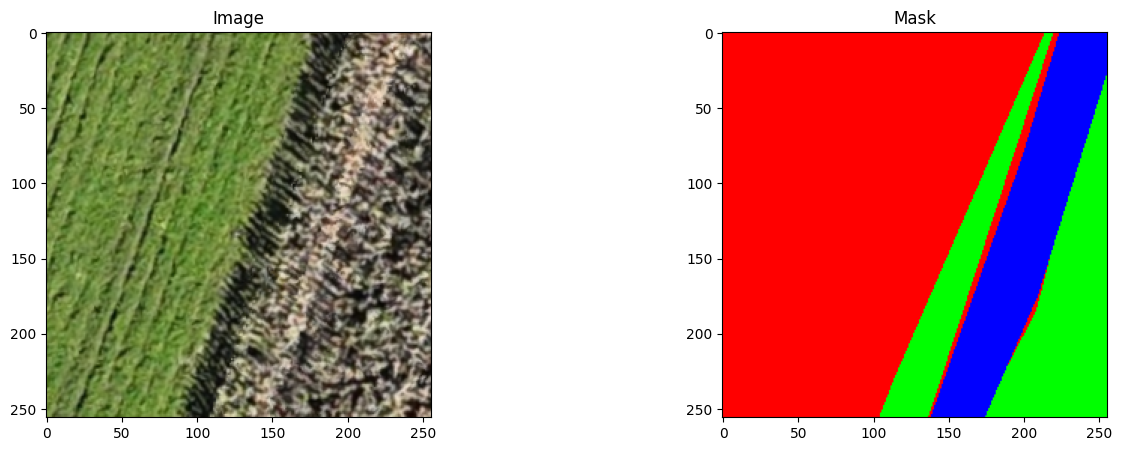

In [28]:
from matplotlib import pyplot as plt
import numpy as np

one_hot_vector1 = torch.tensor([1., 0., 0.]).repeat(256, 256, 1)
one_hot_vector2 = torch.tensor([0., 1., 0.]).repeat(256, 256, 1)
one_hot_vector3 = torch.tensor([0., 0., 1.]).repeat(256, 256, 1)


i = 206
while i < len(val_dataset):
    image, mask = val_dataset[i]
    mask = mask.permute(1, 2, 0)
    comparison1 = mask == one_hot_vector1
    comparison2 = mask == one_hot_vector2
    comparison3 = mask == one_hot_vector3
    judge1 = comparison1.all(dim=2).any().item()
    judge2 = comparison2.all(dim=2).any().item()
    judge3 = comparison3.all(dim=2).any().item()
    if judge1 and judge2 and judge3:
        print(f"{i} {judge1} {judge2} {judge3}")
        break
    i += 1
        
# 显示图像和掩码
image = image.permute(1, 2, 0)
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Image')
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title('Mask')
plt.show()

In [1]:
from sklearn.metrics import accuracy_score, f1_score
import torch
from segmentation_models_pytorch import Unet

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Unet(encoder_name='resnet34',
             encoder_weights='imagenet',
             classes=3,
             activation='softmax'
             ).to(device)
model.load_state_dict(torch.load(f'../model/best_model_epoch_{50}.pth', weights_only=True))
model.eval()
pass

In [5]:
from eval import cal_score
score = cal_score(model, val_dataset)

In [6]:
score

np.float64(97.86857920819438)

In [36]:
image1, mask1 = val_dataset[i]
mask1

# 用 model 预测 image1
with torch.no_grad():
    tmp = image1.unsqueeze(0).to(device)
    output = model(tmp)
    result = (output.squeeze().cpu().numpy())


In [37]:
import numpy as np

# 假设 result 的形状为 (3, 256, 256)
result1 = np.argmax(result, axis=0)  # 找到每个像素点在三个通道中概率最大的那个通道

In [38]:
mask11 = np.argmax(mask1, axis=0)

In [42]:
y_pred = result1
y_true = mask11.cpu().numpy()

# 计算值1：同时为0或者同时不为0的计数值
value1 = np.sum(np.logical_and(y_pred == 0, y_true == 0)) + np.sum(np.logical_and(y_pred != 0, y_true != 0))

# 计算值2：相等的计数值
value2 = np.sum(np.equal(y_pred, y_true))

print(f"Size: {y_pred.size}")
print("Value 1:", value1)
print("Value 2:", value2)

Size: 65536
Value 1: 62881
Value 2: 52743


In [ ]:
result = np.where(result > 0.5, 255, 0)
# 把 result 转为 Tensor
result = torch.tensor(result, dtype=torch.uint8)

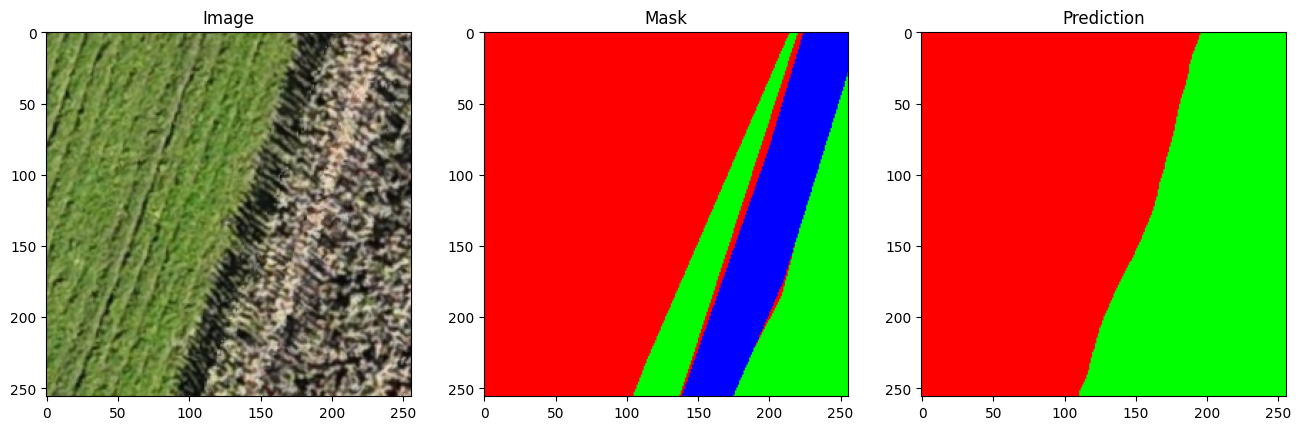

In [31]:
# 显示原始图像、掩码和预测结果
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.imshow(image1.permute(1, 2, 0))
plt.title('Image')
plt.subplot(1, 3, 2)
plt.imshow(mask1.permute(1, 2, 0))
plt.title('Mask')
plt.subplot(1, 3, 3)
plt.imshow(result.permute(1, 2, 0))
plt.title('Prediction')
plt.show()
